# feature extraction for logistic CVD models
load the predictions for the validation model for each.

and compute the confusion matrix, the precision and f1 score (multiclass)
and roc curve maybe? what curves do we use for multiclass.


In [1]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from twaidata.torchdatasets.MRI_3D_nolabels_inram_ds import MRI_3D_nolabels_inram_ds

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
print("banana")

strawberry
banana


In [2]:
import seaborn as sns
import scipy

### Loading predictions

In [3]:
# def get_output_maps_for_ds(output_maps_dir, ids):
#     output_maps_lists = defaultdict(lambda : [])
#     key_order = None
#     for ID in tqdm(ids, position=0, leave=True):
#         output_maps_data = np.load(f"{output_maps_dir}{ID}_out_maps.npz")
#         key_order = natsorted(list(output_maps_data.keys()))
#         for output_type in key_order:
#             output_maps_lists[ID].append(torch.from_numpy(output_maps_data[output_type]))
            
#     return output_maps_lists, key_order
def load_output_maps(output_maps_dir):
    output_maps_lists = defaultdict(lambda: [])
    for fID in tqdm(os.listdir(output_maps_dir), position=0, leave=True):
        # print(fID)
        # break
        if ".npz" in fID:
            ID = fID.split(".")[0]
            output_maps_data = np.load(output_maps_dir+fID)
            key_order = natsorted(list(output_maps_data.keys()))
            for key in key_order:
                output_maps_lists[ID].append(torch.from_numpy(output_maps_data[key]))
    return output_maps_lists, key_order

In [4]:
# model_name = "SSN_Ens_Mean"
model_name = "punet"
output_maps_dir = f"/home/s2208943/ipdis/data/preprocessed_data/EdData_output_maps/{model_name}/"
output_maps_for_umaps, key_order = load_output_maps(output_maps_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [01:07<00:00,  3.82it/s]


In [5]:
# model_name_for_pred = "SSN_Ens_Mean"
model_name_for_pred = "punet"
output_maps_dir_for_pred = f"/home/s2208943/ipdis/data/preprocessed_data/EdData_output_maps/{model_name_for_pred}/"
output_maps_for_pred, key_order_for_pred = load_output_maps(output_maps_dir_for_pred)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:24<00:00, 10.58it/s]


In [56]:
key_order

['ent', 'pred', 'seg']

In [7]:
ID = list(output_maps_for_umaps.keys())[2]

In [8]:
img_us = output_maps_for_umaps[ID]
img_ps = output_maps_for_pred[ID]

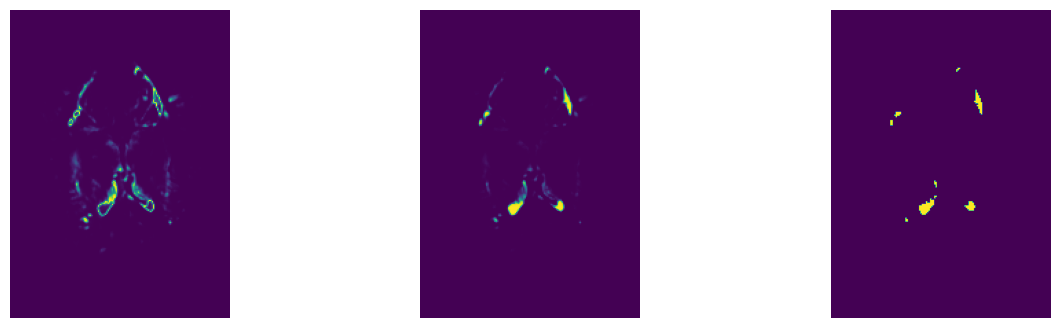

In [9]:
plt.figure(figsize=(15,4))
islice = 31
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(img_us[i][islice])
    plt.axis('off')

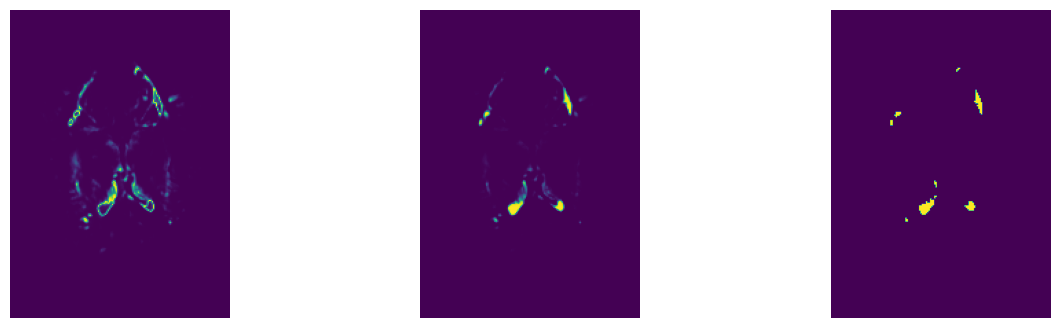

In [10]:
ent, pred, seg = img_ps
plt.figure(figsize=(15,4))
islice = 31
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(img_ps[i][islice])
    plt.axis('off')

In [11]:
t = 0.1
ent_voxels = ent[ent > t]
pred_voxels = pred[pred > t]
# var_voxels = var[var > t/10]

<Axes: ylabel='Density'>

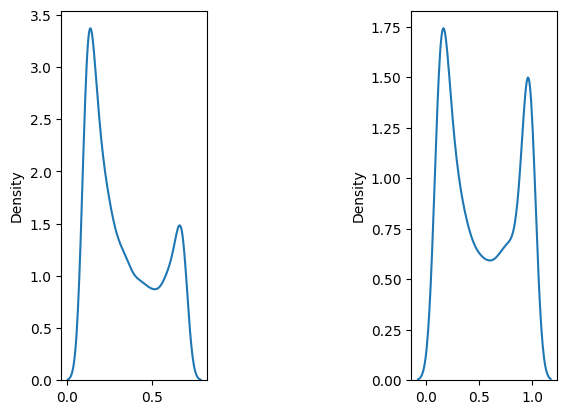

In [12]:
plt.subplot(1,3,1)
sns.kdeplot(ent_voxels)
plt.subplot(1,3,3)
sns.kdeplot(pred_voxels)

In [13]:
def histogram_distribution(values, bins=20, minv=None, maxv=None):
    # so that the output values are meaningful, I need to carefully set the min a max. mnin should be t, and max should be the max across all the data I think.
    if minv == None:
        minv = values.min()
    if maxv == None:
        maxv = values.max()
    counts = torch.zeros(bins)
    bounds = torch.arange(minv,maxv, (maxv-minv)/bins)
    for i, (lower_bound, upper_bound) in enumerate(zip(bounds[:-1], bounds[1:])):
        counts[i] = ((values >= lower_bound) * (values < upper_bound)).sum()

    Z = counts.sum()
    counts = counts / Z
    return counts

In [14]:
def gaussian_summary_statistics(values):
    sum = values.sum().item()
    mean = values.mean().item()
    std = values.std().item()
    skew = scipy.stats.skew(values)
    kurtosis = scipy.stats.kurtosis(values, fisher=False)
    return sum, mean, std, skew, kurtosis

In [15]:
histogram_distribution(ent_voxels, 20)

tensor([0.1710, 0.1149, 0.0894, 0.0682, 0.0614, 0.0505, 0.0441, 0.0392, 0.0405,
        0.0321, 0.0317, 0.0305, 0.0292, 0.0285, 0.0274, 0.0280, 0.0341, 0.0366,
        0.0427, 0.0000])

In [16]:
# counts, counts.sum()

<Axes: ylabel='Count'>

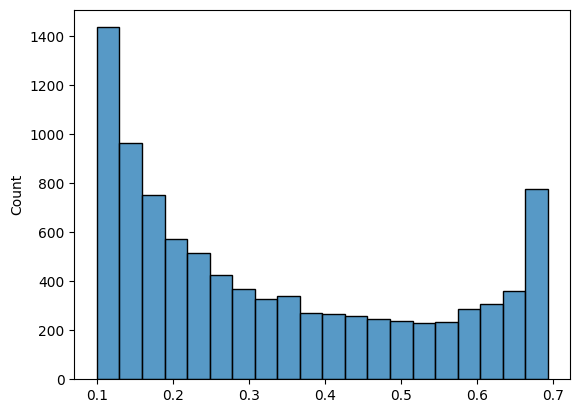

In [17]:
sns.histplot(ent_voxels, bins=20)

### overlap proportions computation
- [x] proportion of segmented area that is uncertain
- [x] proportion of uncertain area that is segmented
- [x] proportion of uncertain area that is within segmentation + edge expansion

In [18]:
def get_edge_expanded_seg(seg, expansions=2):
    expanded = seg.type(torch.float32).unsqueeze(1)
    for _ in range(expansions):
        expanded = torch.nn.functional.max_pool3d(expanded, kernel_size=3, padding=1, stride=1)
    return expanded.type(seg.dtype).squeeze()

### loading the ventricles for ventricle distance analysis

In [19]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.transforms as tv

# resamples an image
def get_resampled_img(itk_image, out_spacing=[2.0, 2.0, 2.0], original_spacing=[1., 1., 3.], is_label=False):
    
    if not original_spacing:
        # orig spacing can be specified when the input itk_image does not know its actual spacing.
        original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    
    # what's this? its how to modify the output size I think...
    out_size = [
        int(np.round(orig_size * orig_spacing / out_spacing))
        for (orig_size, orig_spacing, out_spacing) 
        in zip(original_size, original_spacing, out_spacing)
    ]
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())      # sets the output direction cosine matrix...
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    
    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)
        
    return resample.Execute(itk_image)
      
def resample_and_return(filename_in, is_label=False, out_spacing=[1., 1., 3.], original_spacing=None):
    """
    resamples an image to custom voxel dimensions and returns image as a numpy array
    
    filename_in: .nii.gz file to load
    is_label: is the file a brain scan or a segmentaion mask
    outspacing: the spacing of the image to be resampled to.
    """
        
    # resample the image
    image = sitk.ReadImage(filename_in)
    resampled_image = get_resampled_img(image, out_spacing=out_spacing, original_spacing=original_spacing, is_label=is_label)
    
    return sitk.GetArrayFromImage(resampled_image)

In [20]:
# this loop takes a while as its loading from disk and resampling
# it takes around 11 minutes

cropper = tv.transforms.CenterCrop((224, 160))

def load_fast_output(file, slices):
    timg = resample_and_return(file, is_label=True)
        
    # interpolate the channel number and centre crop
    timg = torch.Tensor(timg)
    timg = torch.nn.functional.interpolate(timg.unsqueeze(0).unsqueeze(0), (slices, *timg.shape[1:])).squeeze()
    timg = cropper(timg.view((1, 1, *timg.shape))).squeeze()
    
    return timg



In [21]:
IDs_outmaps = natsorted(list(output_maps_for_umaps.keys()))
IDs = [("_".join(idx.split("_")[:-2]), idx) for idx in IDs_outmaps if "out_maps" in idx]

In [22]:
IDs_outmaps[0:5], IDs[0:5]

(['CVD001_out_maps',
  'CVD002_out_maps',
  'CVD003_out_maps',
  'CVD004_out_maps',
  'CVD008_out_maps'],
 [('CVD001', 'CVD001_out_maps'),
  ('CVD002', 'CVD002_out_maps'),
  ('CVD003', 'CVD003_out_maps'),
  ('CVD004', 'CVD004_out_maps'),
  ('CVD008', 'CVD008_out_maps')])

In [23]:
output_maps_for_umaps[IDs[0][1]][0].shape

torch.Size([48, 224, 160])

In [24]:
vent_folder = "/home/s2208943/ipdis/data/preprocessed_data/EdData_ventmapper/"
vent_filenames = os.listdir(vent_folder)
ID_ventpath_map = {"_".join(f.split("_")[:-1]): vent_folder + f for f in vent_filenames}
vent_maps = []
for i in tqdm(range(len(IDs)), position=0, leave=True):
    ID = IDs[i]
    num_slices = output_maps_for_umaps[ID[1]][0].shape[0]
    vent_path = ID_ventpath_map[ID[0]]
    vent_seg = load_fast_output(vent_path, num_slices)
    vent_maps.append(vent_seg)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:19<00:00, 12.68it/s]


In [25]:
vent_maps[0].shape, vent_maps[0].sum(dim=(1,2,)).argmax(0)

(torch.Size([48, 224, 160]), tensor(29))

torch.Size([56, 224, 160])
torch.Size([56, 224, 160])


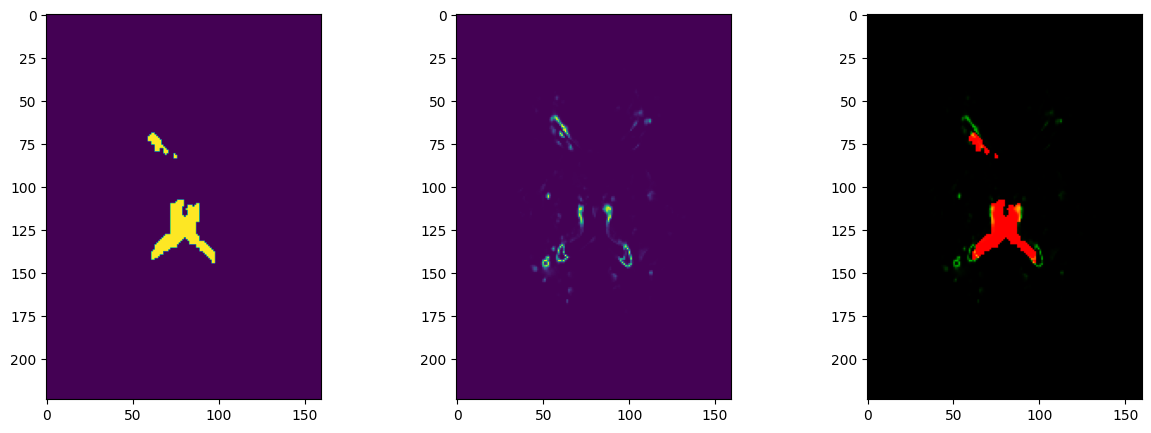

In [26]:
islice = 32
scan_id = 200
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.imshow(vent_maps[scan_id][islice])
plt.subplot(1,3,2)
plt.imshow(output_maps_for_umaps[IDs[scan_id][1]][0][islice])
plt.subplot(1,3,3)
img_map = torch.zeros(*vent_maps[scan_id].shape[1:], 3)
print(output_maps_for_umaps[IDs[scan_id][1]][0].shape)
print(vent_maps[scan_id].shape)
img_map[:,:,0] = vent_maps[scan_id][islice]
img_map[:,:,1] = output_maps_for_umaps[IDs[scan_id][1]][0][islice]
plt.imshow(img_map)

### distance from the ventricles

In [27]:
import torch.nn.functional as F
def edge_pixels_3D(img):
    dtype = img.dtype # preserve original datatype for casting at the end
    img = img.type(torch.float32).unsqueeze(0)
    
    max_pool = F.max_pool3d(img, 3, stride=1, padding=1)
    outer_edge = (max_pool != img).type(torch.float32)
    
    dilated_edge = F.max_pool3d(outer_edge, 3, stride=1, padding=1)
    inner_edge = dilated_edge * img
    
    return inner_edge.type(dtype).squeeze()

def edge_pixels(img):
    dtype = img.dtype # preserve original datatype for casting at the end
    img = img.type(torch.float32)
    
    max_pool = F.max_pool2d(img, 3, stride=1, padding=1)
    outer_edge = (max_pool != img).type(torch.float32)
    
    dilated_edge = F.max_pool2d(outer_edge, 3, stride=1, padding=1)
    inner_edge = dilated_edge * img
    
    return inner_edge.type(dtype)

In [28]:
def downsample_3d(img, avg=True):
    if avg:
        return F.avg_pool3d(img.unsqueeze(0).type(torch.float32), 2, stride=2).squeeze().type(img.dtype)
    else:
        return F.max_pool3d(img.unsqueeze(0).type(torch.float32), 2, stride=2).squeeze().type(img.dtype)

In [29]:
def min_distances(img, vmap):
    # calculate the minimum distance between each point in a and each point in b
    
    spatial_dims = vmap.squeeze().shape
    grid = torch.stack(
            torch.meshgrid(
                *[torch.arange(0, sdi, 1) for sdi in spatial_dims],
                indexing='ij'
            )
        ).type(torch.float32).to(img.device)
    
    a = grid[:, img.squeeze() > 0].T.cuda()
    b = grid[:, vmap.squeeze() > 0].T.cuda()
    
    # Calculate pairwise distances between all pairs of points
    distances = torch.cdist(a, b)

    # Find indices of closest points in b for each point in a
    _, indices = torch.min(distances, dim=1)

    # Use indices to index into b and get closest points
    b_closest = b[indices]

    # Calculate distances to closest points 
    distances_closest = torch.norm(a - b_closest, dim=1)
    
    distance_map = torch.zeros(img.shape).to(distances_closest.device)
    distance_map[img > 0] = distances_closest
    
    return distances_closest, distance_map

### connected components analysis

In [30]:
import cc3d

In [31]:
def get_conn_comps(img):
    connectivity = 6 # only 4,8 (2D) and 26, 18, and 6 (3D) are allowed
    labels_out_seg = cc3d.connected_components(img.cpu().numpy(), connectivity=connectivity)
    return torch.from_numpy(labels_out_seg.astype(np.int16)).to(img.device)

In [32]:
def get_edge_expanded_seg(seg, expansions=2):
    expanded = seg.type(torch.float32).unsqueeze(1)
    for _ in range(expansions):
        expanded = torch.nn.functional.max_pool3d(expanded, kernel_size=3, padding=1, stride=1)
    return expanded.type(seg.dtype).squeeze()

In [33]:
def skew(t, dim=None):
    """
    Computes the skewness of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`tntorch.cross()`).

    :param t: a :class:`Tensor`

    :return: a scalar
    """

    return (((t-t.mean(dim=dim).unsqueeze(dim))/t.std(dim=dim).unsqueeze(dim)).pow(3)).mean(dim=dim)


def kurtosis(t, fisher=True, dim=None):
    """
    Computes the kurtosis of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`tntorch.cross()`).

    :param t: a :class:`Tensor`
    :param fisher: if True (default) Fisher's definition is used, otherwise Pearson's (aka excess)

    :return: a scalar
    """
        
    return (((t-t.mean(dim=dim).unsqueeze(dim))/t.std(dim=dim).unsqueeze(dim)).pow(4)).mean(dim=dim) - fisher*3

In [34]:
def one_hot_encoded_image(image):
    # for a 3D [H, W, D] shape image
    # ensure all IDs are unique
    return (image == image.unique().view(-1, 1, 1, 1))

def one_hot_encoded_vector(vector):
    return (vector == vector.unique().view(-1,1))

In [35]:
def conn_comp_basic_stats(umap, conn_comp_map, seg_map, dist_map):
    # number of connected components
    # size of connected components
    # connected component size distribution information
    cc_ids = conn_comp_map.unique()
    cc_locs = conn_comp_map != 0
    conn_comp_map = conn_comp_map[cc_locs]
    umap = umap[cc_locs]
    seg_map = seg_map[cc_locs]
    dist_map = dist_map[cc_locs]
    
    assert dist_map.shape == seg_map.shape == umap.shape == conn_comp_map.shape
    num_ccs = len(cc_ids) - 1
    num_ccs_no_overlap = 0
    cc_sizes = []
    cc_means = []
    cc_stds = []
    cc_skews = []
    cc_kurts = []
    cc_vent_dists = []
    for cc_id in cc_ids:
        if cc_id == 0:
            continue
        cc = conn_comp_map == cc_id
        cc_size = cc.sum().item()
        cc_values = umap[cc]
        _, mean, std, skew, kurtosis = gaussian_summary_statistics(cc_values.cpu())
    
        cc_sizes.append(cc_size)
        cc_means.append(mean)
        cc_stds.append(std)
        cc_skews.append(skew)
        cc_kurts.append(kurtosis)
        
        if seg_map[cc].sum() == 0:
            num_ccs_no_overlap += 1
            
        cc_vent_dists.append(dist_map[cc].mean().item())
    _, vd_mean, vd_std, vd_skew, vd_kurt = gaussian_summary_statistics(torch.Tensor(cc_vent_dists))
    _, size_mean, size_std, size_skew, size_kurt = gaussian_summary_statistics(torch.Tensor(cc_sizes))
    
    return {"num":num_ccs, "sizes":cc_sizes, "means":cc_means, "stds":cc_stds, "skews":cc_skews, "kurts":cc_kurts, "vent_dists":cc_vent_dists, "unsegmented_ccs":num_ccs_no_overlap, "size_mean":size_mean, "size_std":size_std, "size_skew":size_skew, "size_kurt":size_kurt, "vd_mean":vd_mean, "vd_std":vd_std, "vd_skew":vd_skew, "vd_kurt":vd_kurt}



In [36]:
# idx = 0
# example_umap = output_maps_for_umaps[IDs[idx][1]][0].cuda()
# example_smap = output_maps_for_pred[IDs[idx][1]][2].cuda()
# example_vmap = vent_maps[idx].cuda()

# vmap_ds = downsample_3d(example_vmap)
# umap_ds = downsample_3d(example_umap)
# ut_ds = umap_ds > 0.1
# ut = example_umap > 0.1
# conn_comps = get_conn_comps(ut)

# distances_closest, distance_map = min_distances(ut_ds, vmap_ds)
# distance_map = F.interpolate(distance_map.view(1, 1, *distance_map.shape), example_umap.shape, mode='trilinear').squeeze()

In [37]:
# cc_data = conn_comp_basic_stats(example_umap, conn_comps, example_smap, distance_map) # from this we could get the mean mean, mean std, mean skew and mean kurtosis for each threshold I guess. # that would be somewhat interesting

In [38]:
# cc_data["num"], cc_data["unsegmented_ccs"]

In [39]:
# cc_data["log_sizes"] = torch.Tensor(cc_data['sizes']).log()
# sns.jointplot(cc_data, y="vent_dists", x="log_sizes", bins=5, kind='hist')

In [40]:
def joint_hist_values(data, x, y, minx, maxx, miny, maxy, bins=5):
    values = torch.stack([torch.Tensor(data[x]), torch.Tensor(data[y])], dim=1) # shape [N, 2]
    values = values.expand((bins, bins, *values.shape))
    counts = torch.zeros(bins, bins)
    bounds_x = torch.arange(minx,maxx, (maxx-minx)/(bins+1)).to(values.device)
    bounds_y = torch.arange(miny,maxy, (maxy-miny)/(bins+1)).to(values.device)
    upper_xlims = bounds_x[1:].view(1, 5, 1)
    upper_ylims = bounds_y[1:].view(5, 1, 1)
    lower_xlims = bounds_x[:-1].view(1, 5, 1)
    lower_ylims = bounds_y[:-1].view(5, 1, 1)
    counts = (values[:,:,:,0] < upper_xlims) * (values[:,:,:,0] > lower_xlims) * (values[:,:,:,1] < upper_ylims) * (values[:,:,:,1] > lower_ylims)
    counts = counts.sum(dim=-1)

    Z = counts.sum()
    counts = counts / Z
    return counts


# def joint_hist_values2(data, x, y, minx, maxx, miny, maxy, bins=5):
#     values = torch.stack([torch.Tensor(data[x]), torch.Tensor(data[y])], dim=1) # shape [N, 2]
#     #values = values.expand((bins, bins, *values.shape))
#     counts = torch.zeros(bins, bins)
#     bounds_x = torch.arange(minx,maxx, (maxx-minx)/(bins+1))
#     bounds_y = torch.arange(miny,maxy, (maxy-miny)/(bins+1))
#     upper_xlims = bounds_x[1:]
#     upper_ylims = bounds_y[1:]
#     lower_xlims = bounds_x[:-1]
#     lower_ylims = bounds_y[:-1]
#     for i, (x1, x2) in enumerate(zip(lower_xlims, upper_xlims)):
#         for j, (y1,y2) in enumerate(zip(lower_ylims, upper_ylims)):
#             counts[i][j] = ((values[:,0] < x2) * (values[:,0] > x1) * (values[:,1] < y2) * (values[:,1] > y1)).sum()
#     # counts = counts.sum(dim=-1)

#     Z = counts.sum()
#     counts = counts / Z
#     return counts

In [41]:
# joint_counts = joint_hist_values2(cc_data, "log_sizes", "vent_dists", 0, 8, 0, 10, 5)

In [42]:
# joint_counts.shape

In [43]:
# plt.imshow(joint_counts); plt.colorbar()

In [44]:
# cc_data["num"], cc_data["unsegmented_ccs"]

In [45]:
# summary statistics of log conn comp size:
# cc_summary_stats = gaussian_summary_statistics(torch.Tensor(cc_data['sizes']).log())

In [46]:
# sum, mean , std, skew, kurtosis of log size of connected components.
# cc_summary_stats

In [47]:
# histogram_distribution(torch.Tensor(cc_data['sizes']).log(), 10)

In [48]:
# plt.hist(torch.Tensor(cc_data['sizes']).log(), bins=10);

In [49]:
# sns.jointplot(data=cc_data, x="sizes", y="kurts")
# plt.xscale('log')

In [50]:
# lets get basic distribution of connected component numbers and size. Then we can get some interesting plots later, so collect as much interesting information as possible...
# I can compare this to number and size of connected components in the predicted map (at say tau > 0.5?)
# I should get distance of each connected component from the ventricles and size. yes that is a good plot
# also distance from the binarized segmentation... (but I need to be careful and do this for pred as well as umap).

### Uncertainty values that I intended to extract from the umap

For SSN Ens for the ent and var maps, and SSN Ens Mean for the pred and seg maps. Nice.
I should capture all of these metrics across a variety of metrics, and I can tune the thresholds in cross validation. simples.
It may be the case that ent + var together give us some more information. That would be interesting.

`output_maps_for_umaps` is the SSN_Ens output
`output_maps_for_mean` is the SSN_Ens_mean output

- [x] sum
- [x] mean
- [x] std
- [x] skew
- [x] kurtosis
- [x] kde bins?
- [x] ventricle size
- [x] intensity distribution (need to ensure that the min and max of the bins are the same across all individuals) 
- [x] number of connected components
- [x] size of connected components distribution, need to ensure that the min and max of the bins are the same across all individuals.
- [x] number / distribution of connected components that have no overlap with the segmented mask... (again I need the umap and the pred map to do this) (and I should also compare to the seg map as well perhaps)
- [x] uncertainty sum, mean, skew, kurtosis of each connected component. That may be interesting to plot.
- [-] distance to the WMH binarized segmentation for each connected component (try to separate out those connected components that are highlighting other stuff).
- [-] proportion of the segmented edge deemed uncertain (if we expand the edge of the segmentation then calculate the proportion, we can get the sum of the uncertainty that
- [x] proportion of segmented area deemed uncertain (this requires access to SSN Ens and SSN Ens Mean at the same time
- [x] proportion of uncertain area that is within the segmentation + edge area
- [x] distribution of size of connected components (sum, mean, std, skew)
- [x] distance from the ventricles (could do this in x, y and z distributions, or just overall...) I could measure distance x intensity
- [x] stats for distance from the ventricles (mean, std, skew, kurtosis, etc)
- [x] mean distance from the ventricles of each connected component joint with size in a 5x5 and 10x10 bin option I think. again ensure that the 
- [ ] predicted seg volume.

### turning all of the above into a big loop

need to compute values for:
- [x] ent map
- [x] var map
- [x] pred map
- [x] loop over [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5] as threshold for ent map
- [x] loop over [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] for pred map
- [x] loop over ? for ent map

In [51]:
data = {}
failed_ids = []
for idx in tqdm(range(len(IDs)), position=0, leave=True):
    ID = IDs[idx][0]
    print(ID)
    try:
        vmap = vent_maps[idx].cuda()
        smap = output_maps_for_pred[IDs[idx][1]][2].cuda()
        smap_expanded = get_edge_expanded_seg(smap)
        seg_volume = smap.sum().item()
        vent_volume = vmap.sum().item()
        vmap_ds = downsample_3d(vmap)

        ind_data = {}

        for input_type in ["ent", "pred"]:
            if input_type == "ent":
                umap = output_maps_for_umaps[IDs[idx][1]][0].cuda()
                ts = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]
                maxv = 0.7
            # elif input_type == "var":
            #     umap = output_maps_for_umaps[IDs[idx][1]][3].cuda()
            #     ts = [0.01, 0.03, 0.06, 0.09, 0.12, 0.15]
            #     maxv = 0.2
            elif input_type == "pred":
                umap = output_maps_for_pred[IDs[idx][1]][1].cuda()
                ts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
                maxv = 1.0
            else:
                raise ValueError  

            umap_ds = downsample_3d(umap)

            collected_data_t = {}

            for t in ts:
                ut = umap > t
                umap_values = umap[ut]

                #### summary statistics
                sum, mean, std, skew, kurtosis = gaussian_summary_statistics(umap_values.cpu())
                values_hist = histogram_distribution(umap_values, bins=20, minv=t, maxv=maxv)

                #### overlap statistics
                intersection = (ut * smap).sum()
                expanded_intersection = (ut * smap_expanded).sum()

                prop_umap_segmented = (intersection / ut.sum()).item()
                prop_umap_within_expanded_seg = (expanded_intersection / ut.sum()).item()
                prop_seg_uncertain = (intersection / smap.sum()).item()

                ### ventricle distance statistics
                ut_ds = umap_ds > t
                distances_closest, distance_map = min_distances(ut_ds, vmap_ds)
                distance_map = F.interpolate(distance_map.view(1, 1, *distance_map.shape), umap.shape, mode='trilinear').squeeze()
                _, dist_mean, dist_std, dist_skew, dist_kurt = gaussian_summary_statistics(distances_closest.cpu())
                umap_ds_values = umap_ds[ut_ds]
                dist_value_joint = joint_hist_values({"x":distances_closest, "y":umap_ds_values}, x="x", y="y", minx=0, maxx=30, miny=t, maxy=maxv, bins=5).cpu()

                ### connected component analysis statistics
                conn_comps = get_conn_comps(ut)
                cc_data = conn_comp_basic_stats(umap, conn_comps, smap, distance_map)
                cc_data["log_sizes"] = torch.Tensor(cc_data["sizes"]).log()
                cc_size_dist_joint = joint_hist_values(cc_data, "log_sizes", "vent_dists", 0, 8, 0, 10, 5).cpu()

                # recorded values
                all_data = {}
                for key, value in cc_data.items():
                    all_data["cc_" + key] = value
                all_data["sum"] = sum
                all_data["mean"] = mean
                all_data["std"] = std
                all_data["skew"] = skew
                all_data["kurtosis"] = kurtosis
                all_data["prop_umap_segmented"] = prop_umap_segmented
                all_data["prop_umap_within_expanded_seg"] = prop_umap_within_expanded_seg
                all_data["prop_seg_uncertain"] = prop_seg_uncertain
                all_data["dist_mean"] = dist_mean
                all_data["dist_std"] = dist_std
                all_data["dist_skew"] = dist_skew
                all_data["dist_kurt"] = dist_kurt
                all_data["dist_value_joint"] = dist_value_joint
                all_data["cc_dist_value_joint"] = cc_size_dist_joint
                all_data["seg_volume"] = seg_volume
                all_data["vent_volume"] = vent_volume
                all_data["values_hist"] = values_hist

                print(all_data["cc_num"], all_data["cc_unsegmented_ccs"])
                collected_data_t[str(t)] = all_data


                # break

            ind_data[input_type] = collected_data_t
            # break

        data[ID] = ind_data
        # break
    except:
        failed_ids.append((idx, ID))
    # break
        

  0%|                                                                                                                                                                 | 0/250 [00:00<?, ?it/s]

CVD001


/tmp/ipykernel_345555/1284179010.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = scipy.stats.skew(values)
/tmp/ipykernel_345555/1284179010.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = scipy.stats.kurtosis(values, fisher=False)


147 145
148 144
131 126
118 106
111 95
116 96
130 124
112 95
98 73
92 50


  0%|▌                                                                                                                                                        | 1/250 [00:04<18:34,  4.47s/it]

66 0
64 0
CVD002
330 321
243 228
211 189
206 137
226 121
258 109
179 165
98 82
59 38
56 25
44 0


  1%|█▏                                                                                                                                                       | 2/250 [00:07<15:19,  3.71s/it]

39 0
CVD003
136 120
133 93
285 117
643 173
914 245
1216 345
89 64
58 31
57 25
49 11


  1%|█▊                                                                                                                                                       | 3/250 [00:13<19:09,  4.66s/it]

46 0
40 0
CVD004
205 193
134 112
127 97
128 83
147 81
156 74
114 89
89 57
79 39
70 21
61 0


  2%|██▍                                                                                                                                                      | 4/250 [00:15<15:13,  3.71s/it]

61 0
CVD008
118 91
130 88
230 123
489 181
676 230
916 282
106 60
105 50
96 32
93 19
93 0


  2%|███                                                                                                                                                      | 5/250 [00:20<17:02,  4.17s/it]

96 0
CVD009
302 282
207 178
199 147
276 141
357 149
477 172
147 123
100 73
67 35
53 14
47 0


  2%|███▋                                                                                                                                                     | 6/250 [00:24<16:21,  4.02s/it]

45 0
CVD011
242 223
159 134
153 124
160 111
182 116
202 103
146 116
120 76
109 53
97 27


  3%|████▎                                                                                                                                                    | 7/250 [00:27<14:43,  3.63s/it]

85 0
63 0
CVD012
144 133
87 75
63 45
95 41
153 47
216 66
49 35
41 18
42 13
50 14
43 0


  3%|████▉                                                                                                                                                    | 8/250 [00:29<12:17,  3.05s/it]

41 0
CVD013
145 136
90 67
121 68
167 72
206 75
245 83
62 47
52 34
49 22
42 7


  4%|█████▌                                                                                                                                                   | 9/250 [00:31<11:06,  2.77s/it]

45 0
42 0
CVD014
225 216
170 152
136 113
119 89
131 87
162 94
135 111
104 74
95 57
80 26


  4%|██████                                                                                                                                                  | 10/250 [00:33<10:48,  2.70s/it]

79 0
77 0
CVD016
211 165
231 129
468 175
946 251
1223 309
1523 380
132 73
134 59
121 36
112 19


  4%|██████▋                                                                                                                                                 | 11/250 [00:41<17:26,  4.38s/it]

105 0
99 0
CVD017
95 85
98 80
96 69
98 58
112 61
133 59
74 54
59 36
53 20
51 12


  5%|███████▎                                                                                                                                                | 12/250 [00:43<14:07,  3.56s/it]

46 0
42 0
CVD018
103 103
42 42
25 25
15 15
12 12
9 9
21 21
10 10


/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1304: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/s2208943/miniconda3/envs/wmh/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1417: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
  5%|███████▉                                                                                                                         

4 4
1 1
0 0
0 0
CVD019
130 116
80 61
76 48
107 54
115 54
144 57
60 41
43 21


  6%|████████▌                                                                                                                                               | 14/250 [00:45<09:16,  2.36s/it]

42 16
37 8
32 0
30 0
CVD020
214 185
192 149
164 94
250 98
349 117
484 129
123 64
106 39
97 26
99 24


  6%|█████████                                                                                                                                               | 15/250 [00:49<10:45,  2.75s/it]

86 0
73 0
CVD021
209 165
190 131
236 146
322 141
406 150
501 168
165 103
138 63
128 43
113 18


  6%|█████████▋                                                                                                                                              | 16/250 [00:53<12:27,  3.19s/it]

106 0
91 0
CVD023
258 231
215 168
253 137
413 144
532 158
646 180
136 99
98 57
84 38
65 16


  7%|██████████▎                                                                                                                                             | 17/250 [00:58<13:55,  3.59s/it]

57 0
52 0
CVD024
129 112
122 92
146 82
202 86
244 96
277 88
96 67
67 35
57 23


  7%|██████████▉                                                                                                                                             | 18/250 [01:00<12:33,  3.25s/it]

53 12
44 0
42 0
CVD025
127 112
184 106
518 160
1220 321
1574 424
1931 530
103 74
68 36
67 28
62 14
58 0


  8%|███████████▌                                                                                                                                            | 19/250 [01:09<19:25,  5.05s/it]

56 0
CVD028
168 150
168 126
402 163
1003 267
1409 334
1959 476
110 79
86 45
83 36
89 27
78 0


  8%|████████████▏                                                                                                                                           | 20/250 [01:18<23:32,  6.14s/it]

73 0
CVD030
141 129
95 80
82 63
76 50
77 47
84 47
71 56
54 36
38 19
28 9
24 0


  8%|████████████▊                                                                                                                                           | 21/250 [01:20<18:09,  4.76s/it]

21 0
CVD031
287 265
230 186
339 196
623 254
802 285
1004 312
170 131
139 87
124 58
105 20
115 0


  9%|█████████████▍                                                                                                                                          | 22/250 [01:26<19:55,  5.24s/it]

126 0
CVD032
125 109
97 70
99 63
146 71
189 83
238 90
68 44
63 35
55 25
48 14


  9%|█████████████▉                                                                                                                                          | 23/250 [01:28<16:14,  4.29s/it]

41 0
35 0
CVD033
289 270
200 166
220 135
332 134
462 165
639 214
147 114
97 52
86 34
71 11


 10%|██████████████▌                                                                                                                                         | 24/250 [01:32<16:13,  4.31s/it]

77 0
81 0
CVD034
171 145
148 107
166 93
283 108
370 129
461 133
106 65
105 54
86 30
75 13
75 0


 10%|███████████████▏                                                                                                                                        | 25/250 [01:36<15:13,  4.06s/it]

67 0
CVD035
120 115
67 57
61 39
82 42
91 40
119 50
35 26
31 20
32 18
32 11


 10%|███████████████▊                                                                                                                                        | 26/250 [01:37<12:02,  3.22s/it]

22 0
21 0
CVD036
231 211
243 164
527 183
1125 316
1450 384
1772 461
119 84
84 44
78 34
66 18


 11%|████████████████▍                                                                                                                                       | 27/250 [01:46<18:29,  4.97s/it]

61 0
63 0
CVD037
129 128
21 20
4 3
2 1
2 1
2 1
4 3
2 1
1 0


 11%|█████████████████                                                                                                                                       | 28/250 [01:47<13:25,  3.63s/it]

1 0
1 0
1 0
CVD038
131 109
119 91
132 87
221 108
281 113
369 137
105 76
96 59
88 44
71 21
56 0


 12%|█████████████████▋                                                                                                                                      | 29/250 [01:50<12:36,  3.42s/it]

54 0
CVD039
155 119
162 92
290 108
489 161
598 185
759 213
111 54
109 45
104 32
98 15
101 0


 12%|██████████████████▏                                                                                                                                     | 30/250 [01:55<14:11,  3.87s/it]

103 0
CVD040
150 131
160 109
274 127
507 159
668 207
843 240
85 61
62 28
65 20
70 16
62 0


 12%|██████████████████▊                                                                                                                                     | 31/250 [01:59<15:08,  4.15s/it]

61 0
CVD041
204 190
175 135
333 153
740 226
993 275
1291 347
104 78
75 42
72 33


 13%|███████████████████▍                                                                                                                                    | 32/250 [02:06<17:37,  4.85s/it]

61 18
53 0
53 0
CVD042
124 112
74 60
70 42
98 42
115 41
138 40
48 35
34 20


 13%|████████████████████                                                                                                                                    | 33/250 [02:07<13:52,  3.84s/it]

31 14
28 8
23 0
20 0
CVD043
163 149
132 101
156 85
225 85
275 105
337 113
69 51
60 37
47 18
41 8


 14%|████████████████████▋                                                                                                                                   | 34/250 [02:10<12:33,  3.49s/it]

39 0
36 0
CVD045
153 110
190 120
383 172
795 243
1172 328
1530 417
131 72
116 47
108 32
99 15


 14%|█████████████████████▎                                                                                                                                  | 35/250 [02:18<17:14,  4.81s/it]

104 0
97 0
CVD047
366 346
251 215
241 173
293 155
348 156
432 155
189 150
138 87
113 46
111 26
101 0


 14%|█████████████████████▉                                                                                                                                  | 36/250 [02:22<16:38,  4.67s/it]

91 0
CVD048
244 201
183 125
203 105
352 130
484 152
672 183
141 76
114 40
121 32
116 14


 15%|██████████████████████▍                                                                                                                                 | 37/250 [02:27<16:27,  4.64s/it]

114 0
107 0
CVD049
192 177
140 113
122 79
163 74
192 71
244 80
90 68
70 45
68 33


 15%|███████████████████████                                                                                                                                 | 38/250 [02:29<14:04,  3.98s/it]

57 18
52 0
45 0
CVD050
132 97
128 79
148 76
242 102
300 117
369 121
99 45
95 35
91 26
84 13
79 0


 16%|███████████████████████▋                                                                                                                                | 39/250 [02:32<13:00,  3.70s/it]

75 0
CVD052
445 333
382 240
442 229
613 254
688 253
754 258
294 169
241 104
219 68
200 40
177 0


 16%|████████████████████████▎                                                                                                                               | 40/250 [02:39<16:31,  4.72s/it]

151 0
CVD055
124 112
73 61
69 48
60 33
61 31
76 38
56 42
43 29
36 21


 16%|████████████████████████▉                                                                                                                               | 41/250 [02:41<12:47,  3.67s/it]

31 13
20 0
19 0
CVD056
142 130
97 81
93 66
91 55
109 58
113 50
68 52
51 34
43 21


 17%|█████████████████████████▌                                                                                                                              | 42/250 [02:42<10:32,  3.04s/it]

37 14
28 0
32 0
CVD060
171 134
164 110
228 123
477 181
655 233
863 283
136 80
125 49
128 35
118 12


 17%|██████████████████████████▏                                                                                                                             | 43/250 [02:48<12:48,  3.71s/it]

118 0
113 0
CVD061
182 157
175 138
196 109
342 147
468 180
592 213
120 82
116 65
107 46
106 26


 18%|██████████████████████████▊                                                                                                                             | 44/250 [02:52<13:17,  3.87s/it]

95 0
95 0
CVD063
279 249
209 165
193 123
225 105
258 113
298 115
135 91
112 58
92 34
72 9


 18%|███████████████████████████▎                                                                                                                            | 45/250 [02:55<12:34,  3.68s/it]

78 0
56 0
CVD064
167 157
118 107
106 86
206 112
357 142
613 180
92 78
91 63
83 42
64 20


 18%|███████████████████████████▉                                                                                                                            | 46/250 [02:59<12:22,  3.64s/it]

61 0
61 0
CVD065
300 266
244 191
342 173
700 227
907 270
1098 332
167 122
129 77
106 49
87 22
82 0


 19%|████████████████████████████▌                                                                                                                           | 47/250 [03:05<15:26,  4.57s/it]

84 0
CVD068
169 150
103 76
117 69
155 70
202 80
251 90
73 49
60 31
50 17
46 10


 19%|█████████████████████████████▏                                                                                                                          | 48/250 [03:08<13:02,  3.87s/it]

43 0
43 0
CVD070
288 276
181 161
166 125
250 127
333 134
429 144
133 108
113 76
91 45
76 22


 20%|█████████████████████████████▊                                                                                                                          | 49/250 [03:11<12:37,  3.77s/it]

64 0
55 0
CVD073
258 222
198 153
222 151
314 171
365 173
442 202
155 109
139 83
118 42
116 23
109 0


 20%|██████████████████████████████▍                                                                                                                         | 50/250 [03:15<12:51,  3.86s/it]

112 0
CVD074
221 195
153 125
116 87
148 91
175 92
246 127
116 88
102 68
97 56
67 19
58 0


 20%|███████████████████████████████                                                                                                                         | 51/250 [03:18<11:30,  3.47s/it]

55 0
CVD075
261 248
180 163
141 119
126 88
133 86
130 70
110 94
65 47
53 32
37 13


 21%|███████████████████████████████▌                                                                                                                        | 52/250 [03:20<10:11,  3.09s/it]

26 0
21 0
CVD076
166 120
172 113
205 94
328 112
410 124
526 157
116 57
109 43
100 28
83 9
83 0


 21%|████████████████████████████████▏                                                                                                                       | 53/250 [03:24<10:55,  3.33s/it]

77 0
CVD077
240 229
146 129
169 128
319 145
485 177
705 234
113 95
80 57
71 44


 22%|████████████████████████████████▊                                                                                                                       | 54/250 [03:28<11:28,  3.51s/it]

54 18
46 0
43 0
CVD078
138 99
138 87
189 96
237 112
257 110
274 110
104 52
100 41
90 28
85 17
77 0


 22%|█████████████████████████████████▍                                                                                                                      | 55/250 [03:31<10:46,  3.31s/it]

65 0
CVD079
144 130
107 88
95 64
125 60
135 55
160 59
65 48
50 27
50 18
55 14


 22%|██████████████████████████████████                                                                                                                      | 56/250 [03:33<09:21,  2.89s/it]

52 0
49 0
CVD080
100 88
86 66
113 68
143 70
160 71
183 78
66 47
54 32
45 22
36 10


 23%|██████████████████████████████████▋                                                                                                                     | 57/250 [03:34<08:15,  2.57s/it]

30 0
27 0
CVD081
154 149
117 103
105 86
142 93
177 93
224 100
86 74
69 50
60 35


 23%|███████████████████████████████████▎                                                                                                                    | 58/250 [03:36<07:48,  2.44s/it]

58 20
50 0
42 0
CVD082
133 126
90 80
86 72
68 48
75 49
78 44
75 63
50 36
34 19


 24%|███████████████████████████████████▊                                                                                                                    | 59/250 [03:38<06:45,  2.13s/it]

29 11
22 0
22 0
CVD083
338 315
286 251
288 204
469 228
610 230
821 276
193 156
153 94
146 68
135 45
109 0


 24%|████████████████████████████████████▍                                                                                                                   | 60/250 [03:44<10:11,  3.22s/it]

98 0
CVD084
262 235
158 126
164 111
209 107
240 107
286 104
122 90
86 51
57 20
55 11


 24%|█████████████████████████████████████                                                                                                                   | 61/250 [03:46<09:48,  3.11s/it]

57 0
52 0
CVD085
142 128
81 63
91 50
153 62
193 71
219 72
61 44
59 31
60 22
63 14
63 0


 25%|█████████████████████████████████████▋                                                                                                                  | 62/250 [03:49<08:51,  2.82s/it]

59 0
CVD086
175 148
162 120
178 100
238 86
287 86
340 93
104 68
81 40
68 20
73 16
60 0


 25%|██████████████████████████████████████▎                                                                                                                 | 63/250 [03:52<08:58,  2.88s/it]

55 0
CVD088
194 177
120 98
119 76
170 67
233 78
330 97
82 62
56 30
43 17
40 9


 26%|██████████████████████████████████████▉                                                                                                                 | 64/250 [03:54<08:31,  2.75s/it]

36 0
38 0
CVD089
258 224
183 145
216 136
319 133
393 141
445 137
141 98
106 53
101 39
88 20


 26%|███████████████████████████████████████▌                                                                                                                | 65/250 [03:58<09:42,  3.15s/it]

81 0
80 0
CVD090
125 112
103 81
107 77
120 62
143 62
169 61
85 66
62 38
47 22
41 11


 26%|████████████████████████████████████████▏                                                                                                               | 66/250 [04:00<08:28,  2.77s/it]

33 0
30 0
CVD091
132 124
81 66
88 66
90 53
101 50
107 48
79 62
60 39
41 17


 27%|████████████████████████████████████████▋                                                                                                               | 67/250 [04:02<07:18,  2.39s/it]

36 8
33 0
25 0
CVD092
128 122
78 70
73 58
91 45
111 48
138 51
48 40
30 20


 27%|█████████████████████████████████████████▎                                                                                                              | 68/250 [04:03<06:21,  2.10s/it]

24 10
22 5
20 0
20 0
CVD096
191 175
122 101
109 79
104 62
117 57
131 61
92 68
64 37
52 23
47 16


 28%|█████████████████████████████████████████▉                                                                                                              | 69/250 [04:05<06:07,  2.03s/it]

37 0
38 0
CVD097
150 129
100 76
116 74
144 59
155 47
173 45
84 58
53 21
48 14
51 11


 28%|██████████████████████████████████████████▌                                                                                                             | 70/250 [04:07<06:04,  2.03s/it]

45 0
51 0
CVD098
171 147
110 80
127 73
202 88
266 103
346 124
80 51
60 28
54 18
49 10


 28%|███████████████████████████████████████████▏                                                                                                            | 71/250 [04:09<06:33,  2.20s/it]

53 0
40 0
CVD100
164 152
119 97
109 75
150 81
184 85
233 84
81 60
70 42
54 25
40 7


 29%|███████████████████████████████████████████▊                                                                                                            | 72/250 [04:12<06:29,  2.19s/it]

39 0
32 0
CVD102
214 201
192 167
274 170
606 206
898 255
1191 321
123 96
93 59
82 39
76 24


 29%|████████████████████████████████████████████▍                                                                                                           | 73/250 [04:18<09:53,  3.35s/it]

68 0
64 0
CVD103
148 130
114 88
116 79
207 91
331 118
558 157
99 73
75 45
70 32
67 23
63 0


 30%|████████████████████████████████████████████▉                                                                                                           | 74/250 [04:21<09:39,  3.29s/it]

57 0
CVD104
193 183
127 115
82 63
93 45
115 50
138 46
68 54
40 20
42 16
39 9


 30%|█████████████████████████████████████████████▌                                                                                                          | 75/250 [04:23<08:15,  2.83s/it]

33 0
31 0
CVD105
85 71
62 46
64 44
82 45
105 50
140 54
49 33
47 27


 30%|██████████████████████████████████████████████▏                                                                                                         | 76/250 [04:24<06:58,  2.41s/it]

42 19
35 8
33 0
29 0
CVD106
145 110
147 102
227 113
501 166
705 200
971 267
112 63
107 45
97 31
96 16
104 0


 31%|██████████████████████████████████████████████▊                                                                                                         | 77/250 [04:29<09:28,  3.29s/it]

108 0
CVD107
99 88
119 81
249 117
641 193
953 269
1245 360
69 42
75 40
64 24


 31%|███████████████████████████████████████████████▍                                                                                                        | 78/250 [04:35<11:34,  4.04s/it]

52 10
51 0
50 0
CVD108
170 142
132 92
155 97
196 99
221 103
246 98
112 76
93 51
85 34
89 29
66 0


 32%|████████████████████████████████████████████████                                                                                                        | 79/250 [04:38<10:21,  3.64s/it]

62 0
CVD111
286 258
242 186
325 189
472 208
620 223
790 269
182 130
149 74
143 56
156 44
139 0


 32%|████████████████████████████████████████████████▋                                                                                                       | 80/250 [04:44<12:06,  4.28s/it]

127 0
CVD112
278 221
230 163
256 143
360 158
438 178
543 208
195 115
171 80
149 46
146 29


 32%|█████████████████████████████████████████████████▏                                                                                                      | 81/250 [04:48<12:32,  4.45s/it]

130 0
117 0
CVD113
246 238
151 140
129 114
123 88
138 79
161 73
118 103
83 57
64 27


 33%|█████████████████████████████████████████████████▊                                                                                                      | 82/250 [04:51<10:40,  3.81s/it]

66 20
55 0
54 0
CVD114
152 108
142 82
196 87
305 108
386 129
445 150
98 45
83 27
79 16
82 13
72 0


 33%|██████████████████████████████████████████████████▍                                                                                                     | 83/250 [04:54<10:16,  3.69s/it]

66 0
CVD115
134 111
120 78
247 98
556 153
806 219
1085 298
91 56
97 56
76 28
70 18
61 0


 34%|███████████████████████████████████████████████████                                                                                                     | 84/250 [05:00<11:36,  4.20s/it]

57 0
CVD116
168 146
118 90
109 73
135 75
146 69
174 66
85 61
65 39
55 24
50 15


 34%|███████████████████████████████████████████████████▋                                                                                                    | 85/250 [05:02<09:45,  3.55s/it]

42 0
44 0
CVD117
282 270
213 186
207 139
289 151
324 133
356 137
145 120
104 70
97 38
91 20


 34%|████████████████████████████████████████████████████▎                                                                                                   | 86/250 [05:05<09:46,  3.58s/it]

91 0
76 0
CVD118
285 266
176 149
262 151
617 203
981 308
1359 410
123 103
93 65
81 48
71 24


 35%|████████████████████████████████████████████████████▉                                                                                                   | 87/250 [05:12<12:06,  4.46s/it]

60 0
57 0
CVD121
223 192
162 122
167 106
221 121
249 131
277 128
138 90
136 75
118 47
103 22
95 0


 35%|█████████████████████████████████████████████████████▌                                                                                                  | 88/250 [05:15<11:01,  4.08s/it]

82 0
CVD124
303 277
220 187
186 138
269 139
356 166
499 195
152 113
118 74
97 46
73 14
71 0


 36%|██████████████████████████████████████████████████████                                                                                                  | 89/250 [05:19<10:49,  4.03s/it]

73 0
CVD126
181 145
163 108
218 111
395 132
530 154
656 180
135 88
85 29
80 18
82 15


 36%|██████████████████████████████████████████████████████▋                                                                                                 | 90/250 [05:23<10:59,  4.12s/it]

75 0
82 0
CVD127
153 133
113 90
120 74
160 78
177 70
212 88
76 51
57 29
54 19
53 10


 36%|███████████████████████████████████████████████████████▎                                                                                                | 91/250 [05:25<09:22,  3.54s/it]

53 0
47 0
CVD128
125 114
97 84
88 65
130 55
175 60
231 76
64 49
47 30
31 14
22 4
18 0


 37%|███████████████████████████████████████████████████████▉                                                                                                | 92/250 [05:27<07:58,  3.03s/it]

19 0
CVD129
147 136
143 124
149 101
263 123
424 174
635 229
111 89
103 71
89 49
79 26
70 0


 37%|████████████████████████████████████████████████████████▌                                                                                               | 93/250 [05:31<08:28,  3.24s/it]

75 0
CVD130
200 187
121 104
114 90
126 70
133 65
145 62
93 77
53 37
39 19
29 7
23 0


 38%|█████████████████████████████████████████████████████████▏                                                                                              | 94/250 [05:33<07:23,  2.84s/it]

19 0
CVD132
230 223
140 132
85 77
80 65
73 54
85 57
83 75
55 41
49 31
52 21


 38%|█████████████████████████████████████████████████████████▊                                                                                              | 95/250 [05:35<06:31,  2.53s/it]

40 0
47 0
CVD133
85 72
51 37
53 30
73 36
81 34
100 42
35 21
32 18
29 10


 38%|██████████████████████████████████████████████████████████▎                                                                                             | 96/250 [05:36<05:25,  2.12s/it]

25 4
23 0
21 0
CVD134
139 115
118 82
155 69
314 99
443 127
597 179
81 48
84 43
90 38
75 21
62 0


 39%|██████████████████████████████████████████████████████████▉                                                                                             | 97/250 [05:39<06:31,  2.56s/it]

62 0
CVD137
173 159
120 99
126 88
192 91
249 111
299 113
92 73
77 50
61 25


 39%|███████████████████████████████████████████████████████████▌                                                                                            | 98/250 [05:42<06:29,  2.56s/it]

49 10
52 0
47 0
CVD138
280 266
181 163
132 106
150 91
188 88
285 108
109 90
70 45
63 31


 40%|████████████████████████████████████████████████████████████▏                                                                                           | 99/250 [05:45<06:33,  2.60s/it]

58 14
55 0
48 0
CVD140
154 123
168 94
261 91
468 137
585 172
700 204
85 44
74 29
71 21
72 15
68 0


 40%|████████████████████████████████████████████████████████████▍                                                                                          | 100/250 [05:49<07:51,  3.15s/it]

67 0
CVD141
239 216
192 159
181 132
219 125
245 120
303 129
150 109
129 79
115 55
94 17
91 0


 40%|█████████████████████████████████████████████████████████████                                                                                          | 101/250 [05:52<07:55,  3.19s/it]

68 0
CVD143
192 170
158 132
154 114
177 99
216 99
293 109
130 93
86 46
76 31
71 18


 41%|█████████████████████████████████████████████████████████████▌                                                                                         | 102/250 [05:55<07:33,  3.07s/it]

63 0
54 0
CVD145
88 73
77 57
76 47
107 53
130 57
192 80
60 35
57 28
53 20
44 7


 41%|██████████████████████████████████████████████████████████████▏                                                                                        | 103/250 [05:57<06:29,  2.65s/it]

47 0
41 0
CVD146
270 250
192 152
229 123
328 107
407 124
518 142
125 95
76 43
71 33
58 15
48 0


 42%|██████████████████████████████████████████████████████████████▊                                                                                        | 104/250 [06:01<07:16,  2.99s/it]

42 0
CVD148
178 160
126 102
134 83
172 86
176 74
203 76
87 65
56 32
44 17
41 9


 42%|███████████████████████████████████████████████████████████████▍                                                                                       | 105/250 [06:03<06:39,  2.75s/it]

35 0
27 0
CVD150
190 163
115 74
174 74
287 86
352 99
406 104
73 47
57 28
50 16
47 12


 42%|████████████████████████████████████████████████████████████████                                                                                       | 106/250 [06:06<06:45,  2.82s/it]

38 0
34 0
CVD151
200 178
157 115
210 108
366 154
471 163
597 189
109 77
84 49
78 36


 43%|████████████████████████████████████████████████████████████████▋                                                                                      | 107/250 [06:10<07:31,  3.16s/it]

63 17
56 0
49 0
CVD152
223 210
167 147
167 125
272 138
365 151
495 171
126 108
100 72
79 45
68 26


 43%|█████████████████████████████████████████████████████████████████▏                                                                                     | 108/250 [06:13<07:42,  3.26s/it]

52 0
54 0
CVD153
217 188
185 137
231 122
415 169
567 200
712 219
100 70
76 41
53 13
55 9
60 0


 44%|█████████████████████████████████████████████████████████████████▊                                                                                     | 109/250 [06:18<08:27,  3.60s/it]

54 0
CVD155
53 44
41 28
54 26
93 33
119 39
150 54
29 19
26 13
19 4


 44%|██████████████████████████████████████████████████████████████████▍                                                                                    | 110/250 [06:19<06:43,  2.88s/it]

21 2
24 0
22 0
CVD156
152 128
116 80
160 94
253 115
345 137
457 152
105 69
88 43
83 24
91 22
92 0


 44%|███████████████████████████████████████████████████████████████████                                                                                    | 111/250 [06:22<06:59,  3.02s/it]

89 0
CVD157
177 166
108 92
144 96
318 106
528 156
816 192
90 75
61 42
45 21
34 7


 45%|███████████████████████████████████████████████████████████████████▋                                                                                   | 112/250 [06:26<07:32,  3.28s/it]

36 0
37 0
CVD158
330 290
289 215
412 221
598 256
731 280
879 320
210 152
162 96
137 54
128 26


 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 113/250 [06:33<09:40,  4.24s/it]

125 0
115 0
CVD161
158 137
117 95
114 79
182 77
250 83
313 85
89 65
60 33
48 19
45 13


 46%|████████████████████████████████████████████████████████████████████▊                                                                                  | 114/250 [06:35<08:23,  3.70s/it]

35 0
32 0
CVD165
334 312
208 180
154 113
164 94
203 104
243 97
120 86
115 73
86 43
73 26


 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 115/250 [06:38<07:50,  3.49s/it]

54 0
45 0
CVD166
428 388
340 271
383 238
558 235
692 236
858 272
228 166
185 105
163 67
138 26
130 0


 46%|██████████████████████████████████████████████████████████████████████                                                                                 | 116/250 [06:45<09:53,  4.43s/it]

123 0
CVD167
210 194
170 140
188 120
432 156
665 200
937 254
118 92
87 57
79 45
66 20


 47%|██████████████████████████████████████████████████████████████████████▋                                                                                | 117/250 [06:50<10:07,  4.57s/it]

64 0
56 0
CVD169
151 134
109 89
105 77
110 68
131 64
164 74
86 62
70 39
64 26
71 21
58 0


 47%|███████████████████████████████████████████████████████████████████████▎                                                                               | 118/250 [06:52<08:24,  3.82s/it]

66 0
CVD170
154 142
115 92
151 82
392 150
597 194
825 256
82 56
74 37
67 25
62 13
59 0


 48%|███████████████████████████████████████████████████████████████████████▉                                                                               | 119/250 [06:56<08:35,  3.94s/it]

58 0
CVD171
222 214
131 116
114 94
129 74
169 76
213 77
93 76
72 49
58 29
46 12


 48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 120/250 [06:58<07:28,  3.45s/it]

47 0
41 0
CVD172
364 309
270 206
246 151
288 150
318 148
343 150
184 123
142 76
116 43
105 20
89 0


 48%|█████████████████████████████████████████████████████████████████████████                                                                              | 121/250 [07:02<07:47,  3.63s/it]

80 0
CVD173
362 334
249 210
350 193
732 255
1072 344
1414 441
179 138
132 83
110 58
87 31
69 0


 49%|█████████████████████████████████████████████████████████████████████████▋                                                                             | 122/250 [07:10<10:11,  4.78s/it]

58 0
CVD174
115 102
86 67
132 84
282 110
495 180
743 234
79 59
69 42
67 32
59 15
53 0


 49%|██████████████████████████████████████████████████████████████████████████▎                                                                            | 123/250 [07:13<09:23,  4.44s/it]

55 0
CVD175
96 91
70 58
76 56
102 48
139 62
193 76
65 52
51 34
38 19
47 15


 50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 124/250 [07:15<07:34,  3.61s/it]

48 0
41 0
CVD176
155 133
134 101
165 100
304 135
387 147
453 133
99 67
85 46
68 22
65 10
65 0


 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 125/250 [07:18<07:19,  3.51s/it]

56 0
CVD177
192 177
133 115
133 85
211 85
280 93
333 97
84 63
61 33
57 25
55 11
58 0


 50%|████████████████████████████████████████████████████████████████████████████                                                                           | 126/250 [07:21<06:46,  3.28s/it]

63 0
CVD178
111 93
85 56
153 70
242 72
303 92
343 104
60 43
40 21


 51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 127/250 [07:23<06:13,  3.03s/it]

35 13
31 7
28 0
31 0
CVD179
188 167
183 140
321 156
720 242
973 273
1277 349
112 81
96 58
83 39
76 24
68 0


 51%|█████████████████████████████████████████████████████████████████████████████▎                                                                         | 128/250 [07:30<08:16,  4.07s/it]

62 0
CVD181
164 141
164 109
293 116
684 205
939 259
1207 348
94 57
74 29
77 27
69 10
71 0


 52%|█████████████████████████████████████████████████████████████████████████████▉                                                                         | 129/250 [07:36<09:25,  4.68s/it]

65 0
CVD183
72 63
57 43
78 45
111 49
136 62
165 74
55 38
46 26
39 15
43 10
42 0


 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 130/250 [07:38<07:28,  3.74s/it]

31 0
CVD184
225 219
151 145
120 107
127 95
134 83
188 101
109 96
84 66
63 42


 52%|███████████████████████████████████████████████████████████████████████████████                                                                        | 131/250 [07:40<06:31,  3.29s/it]

52 22
44 0
42 0
CVD186
215 208
175 163
131 110
161 105
196 108
285 123
121 103
100 77
92 59
92 41


 53%|███████████████████████████████████████████████████████████████████████████████▋                                                                       | 132/250 [07:43<06:14,  3.17s/it]

83 0
67 0
CVD188
295 253
273 172
484 200
757 236
923 290
1037 324
144 98
113 58
109 44
111 29


 53%|████████████████████████████████████████████████████████████████████████████████▎                                                                      | 133/250 [07:50<08:21,  4.29s/it]

94 0
82 0
CVD191
401 371
265 216
276 168
464 171
658 185
893 240
174 125
130 73
114 46
110 25
111 0


 54%|████████████████████████████████████████████████████████████████████████████████▉                                                                      | 134/250 [07:55<09:11,  4.75s/it]

97 0
CVD192
196 186
132 114
130 104
127 88
146 92
166 77
121 100
84 54
73 40


 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 135/250 [07:58<07:39,  4.00s/it]

61 23
56 0
54 0
CVD193
302 292
246 231
159 142
138 112
122 91
102 66
153 136
105 81
64 35
55 18
50 0


 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 136/250 [08:00<06:45,  3.56s/it]

33 0
CVD194
119 107
70 57
59 44
71 43
83 44
90 39
57 40
40 20
42 20


 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 137/250 [08:02<05:26,  2.89s/it]

31 7
37 0
31 0
CVD195
134 127
133 102
309 109
885 232
1199 299
1509 375
51 41
32 18


 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 138/250 [08:08<07:38,  4.09s/it]

29 14
29 10
23 0
19 0
CVD200
198 181
180 151
177 126
331 145
443 168
629 191
113 86
96 54
81 31
75 20
68 0


 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                   | 139/250 [08:12<07:29,  4.05s/it]

64 0
CVD201
132 116
85 65
88 61
105 57
128 59
165 67
70 48
61 34
54 25
39 8


 56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 140/250 [08:14<06:10,  3.36s/it]

39 0
35 0
CVD202
126 117
119 94
335 149
935 233
1386 370
1789 500
77 63
44 27
43 24
33 9


 56%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 141/250 [08:22<08:27,  4.66s/it]

29 0
30 0
CVD203
134 115
114 82
166 76
388 125
558 160
735 190
87 46
76 25
75 20
65 8
63 0


 57%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 142/250 [08:26<08:03,  4.48s/it]

62 0
CVD204
86 72
104 56
273 80
528 127
667 166
774 198
44 25
42 19
40 13
44 9
48 0


 57%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                | 143/250 [08:30<07:53,  4.42s/it]

55 0
CVD205
123 109
139 101
264 115
628 198
905 276
1252 364
93 63
82 42
85 31
87 23
81 0


 58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                | 144/250 [08:36<08:39,  4.90s/it]

83 0
CVD206
179 161
157 129
138 88
169 79
196 74
270 85
97 75
65 42
49 23
42 12


 58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 145/250 [08:39<07:16,  4.16s/it]

34 0
29 0
CVD207
198 190
190 174
158 137
154 100
208 103
258 105
138 120
77 54
73 39
65 25


 58%|████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 146/250 [08:41<06:26,  3.71s/it]

45 0
48 0
CVD208
231 221
158 134
166 116
267 120
347 131
444 145
120 100
100 67
83 42
70 20


 59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 147/250 [08:45<06:14,  3.64s/it]

63 0
67 0
CVD213
77 69
85 70
100 57
160 62
183 60
215 67
56 43
40 25


 59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 148/250 [08:47<05:14,  3.08s/it]

30 13
29 8
30 0
25 0
CVD214
154 133
102 73
178 77
447 127
667 159
923 223
60 36
53 23
44 12
42 5


 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 149/250 [08:51<05:51,  3.48s/it]

44 0
43 0
CVD216
252 237
169 145
162 122
173 94
202 105
231 113
131 101
95 57
90 41
80 20


 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 150/250 [08:54<05:27,  3.27s/it]

69 0
65 0
CVD218
268 255
183 166
142 112
199 114
271 129
373 143
126 102
93 64
66 31
55 15
48 0


 60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 151/250 [08:57<05:20,  3.24s/it]

42 0
CVD219
149 126
106 74
127 71
172 76
200 68
256 82
89 54
72 34
67 24
73 22
65 0


 61%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 152/250 [08:59<04:58,  3.05s/it]

66 0
CVD220
109 97
87 68
97 49
187 67
229 78
274 79
53 34
54 32
41 16
38 9


 61%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 153/250 [09:02<04:27,  2.76s/it]

33 0
29 0
CVD221
277 263
171 155
152 124
169 110
211 113
258 114
135 112
110 83
77 46
63 21


 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                          | 154/250 [09:04<04:27,  2.78s/it]

54 0
42 0
CVD225
212 179
181 134
219 120
405 143
587 179
782 206
120 78
96 54
82 36
64 14
53 0


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 155/250 [09:09<05:14,  3.31s/it]

54 0
CVD226
176 137
121 79
124 68
173 84
195 89
198 76
91 50
77 35
66 22


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 156/250 [09:11<04:42,  3.01s/it]

59 13
51 0
52 0
CVD229
245 219
173 142
161 123
134 85
156 92
169 82
150 113
113 69
91 41
75 19


 63%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 157/250 [09:14<04:28,  2.89s/it]

69 0
59 0
CVD230
223 208
153 134
119 94
158 111
196 112
244 127
110 90
103 78
90 58
74 23
76 0


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 158/250 [09:17<04:20,  2.83s/it]

75 0
CVD231
148 110
123 81
125 66
179 74
234 81
317 113
92 46
84 29
82 24
73 10
75 0


 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 159/250 [09:19<04:12,  2.77s/it]

64 0
CVD233
181 165
157 115
279 127
571 190
793 249
972 292
91 65
80 48
65 27
60 11
62 0


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 160/250 [09:25<05:18,  3.53s/it]

61 0
CVD234
141 130
127 110
141 79
281 87
363 105
462 127
79 59
77 51
66 33


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 161/250 [09:28<05:02,  3.40s/it]

56 21
46 0
33 0
CVD235
147 136
108 96
78 64
70 47
83 45
97 49
69 56
50 34
36 18


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 162/250 [09:29<04:07,  2.81s/it]

29 7
24 0
16 0
CVD236
151 129
108 76
113 56
186 68
239 83
338 109
79 46
75 37
56 17


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 163/250 [09:32<03:56,  2.72s/it]

56 12
48 0
45 0
CVD237
200 179
200 146
260 131
589 194
896 252
1249 314
119 75
107 55
91 34
85 16
81 0


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 164/250 [09:38<05:23,  3.77s/it]

79 0
CVD238
270 247
186 144
199 116
276 121
316 125
361 134
106 74
87 47
84 32
84 21
77 0


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 165/250 [09:41<05:11,  3.67s/it]

64 0
CVD239
201 178
170 127
214 116
397 152
571 198
818 265
111 72
86 46
77 30
73 21
74 0


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 166/250 [09:46<05:31,  3.94s/it]

78 0
CVD240
176 155
110 83
94 63
102 56
124 59
146 67
82 57
60 32
48 19
43 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 167/250 [09:48<04:35,  3.31s/it]

39 0
35 0
CVD241
68 53
152 73
556 121
1226 240
1590 336
1912 433
37 24
32 17


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 168/250 [09:56<06:47,  4.97s/it]

27 9
23 2
24 0
18 0
CVD242
198 166
182 122
318 157
737 266
1095 354
1445 423
133 81
116 53
112 42
99 18


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 169/250 [10:04<07:39,  5.67s/it]

102 0
103 0
CVD245
226 204
191 165
159 121
163 101
179 97
206 100
125 96
87 51
78 39
55 16
41 0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 170/250 [10:06<06:18,  4.73s/it]

35 0
CVD246
286 260
181 142
141 92
173 90
208 91
248 100
109 69
99 50
87 34
88 27
68 0


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 171/250 [10:09<05:29,  4.17s/it]

64 0
CVD247
205 176
152 111
197 116
252 114
299 122
365 149
135 86
121 62
110 46
100 23


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 172/250 [10:13<05:06,  3.93s/it]

87 0
70 0
CVD248
145 128
90 71
91 49
155 61
207 62
289 68
61 39
49 23
46 15
45 8


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 173/250 [10:15<04:21,  3.40s/it]

42 0
40 0
CVD249
124 112
127 97
250 120
570 188
746 246
967 324
79 57
60 32
55 21


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 174/250 [10:20<04:55,  3.89s/it]

55 10
53 0
50 0
CVD250
212 177
167 123
191 101
312 121
407 138
526 169
112 68
93 38
92 25
98 21
89 0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 175/250 [10:24<04:57,  3.96s/it]

78 0
CVD251
244 215
169 133
148 92
184 86
221 92
272 94
115 78
83 42
62 18


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 176/250 [10:27<04:26,  3.60s/it]

54 4
55 0
51 0
CVD252
132 117
142 99
218 104
488 149
674 187
931 266
71 48
74 44
62 28
56 11
61 0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 177/250 [10:31<04:47,  3.94s/it]

50 0
CVD253
126 94
101 64
107 60
121 57
136 53
164 58
76 39
65 26
60 19


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 178/250 [10:33<04:01,  3.36s/it]

52 7
52 0
49 0
CVD254
235 215
188 159
168 127
203 134
270 145
365 168
154 115
120 69
107 49
82 17
83 0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 179/250 [10:37<04:00,  3.39s/it]

70 0
CVD255
252 241
187 161
198 136
393 170
576 190
837 241
137 115
113 81
73 34
65 17


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 180/250 [10:42<04:25,  3.79s/it]

64 0
55 0
CVD256
152 144
73 62
67 53
69 46
74 38
86 34
55 42
45 31
33 17


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 181/250 [10:43<03:31,  3.06s/it]

31 10
25 0
21 0
CVD257
306 295
197 180
129 98
127 81
129 73
143 65
117 95
68 46
55 29
47 12


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 182/250 [10:45<03:13,  2.84s/it]

40 0
38 0
CVD258
164 141
123 94
136 96
315 143
467 175
704 247
106 73
89 37
99 37
92 16
102 0


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 183/250 [10:49<03:35,  3.21s/it]

85 0
CVD259
231 213
180 156
134 97
172 101
190 86
228 80
114 85
75 43
61 24


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 184/250 [10:52<03:20,  3.03s/it]

57 14
57 0
46 0
CVD260
145 129
118 92
125 76
183 78
238 85
333 102
78 53
64 29
70 22
71 14
74 0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 185/250 [10:55<03:10,  2.93s/it]

64 0
CVD261
233 223
166 149
141 114
156 94
200 102
254 97
118 98
85 61
59 31


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 186/250 [10:57<03:02,  2.85s/it]

50 15
46 0
35 0
CVD262
234 220
138 121
103 81
81 51
87 49
87 36
96 76
63 37
60 30


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 187/250 [10:59<02:41,  2.56s/it]

59 23
45 0
48 0
CVD263
116 105
102 84
97 67
133 68
138 60
172 61
79 56
67 36
67 29


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 188/250 [11:01<02:28,  2.39s/it]

53 13
50 0
47 0
CVD264
161 144
110 89
103 64
150 78
168 70
194 71
78 53
61 33
49 19
39 6


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 189/250 [11:03<02:19,  2.29s/it]

40 0
30 0
CVD265
304 270
203 164
179 128
214 110
270 121
347 116
161 114
116 61
95 36
86 14


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 190/250 [11:07<02:39,  2.65s/it]

88 0
76 0
CVD266
271 264
239 220
240 180
390 199
524 228
718 258
172 151
139 104
118 72
98 37
94 0


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 191/250 [11:12<03:18,  3.36s/it]

90 0
CVD267
145 125
95 71
104 67
144 63
170 69
193 71
73 45
54 23
50 17
47 8


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 192/250 [11:14<02:51,  2.96s/it]

45 0
37 0
CVD268
255 228
182 138
279 148
684 240
1003 321
1346 413
124 84
110 62
104 48
90 24
77 0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 193/250 [11:21<03:54,  4.11s/it]

69 0
CVD269
200 178
176 121
247 130
451 155
594 174
749 210
118 80
104 55
92 33
82 16


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 194/250 [11:25<04:01,  4.31s/it]

74 0
71 0
CVD270
250 230
179 141
181 113
262 121
332 128
407 126
122 86
91 50
72 26
61 12


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 195/250 [11:29<03:42,  4.05s/it]

55 0
50 0
CVD271
333 298
225 181
183 131
174 95
202 97
214 84
165 122
100 52
106 51
81 23


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 196/250 [11:32<03:23,  3.78s/it]

66 0
54 0
CVD272
112 101
78 64
81 62
81 52
93 50
114 56
73 55
61 40
51 29
38 11
36 0


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 197/250 [11:33<02:44,  3.11s/it]

32 0
CVD273
150 137
103 86
86 61
97 53
114 60
126 54
68 52
50 33
34 15
25 5
26 0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 198/250 [11:35<02:18,  2.67s/it]

28 0
CVD274
282 264
171 149
117 90
118 71
127 66
166 70
107 81
82 46
73 32


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 199/250 [11:37<02:11,  2.58s/it]

63 15
49 0
48 0
CVD275
237 215
198 166
223 147
425 188
603 215
808 269
143 114
122 83
95 49
75 21
75 0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 200/250 [11:42<02:44,  3.29s/it]

79 0
CVD276
141 116
97 68
122 58
195 75
231 73
257 70
79 49
64 33
49 17
46 10


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 201/250 [11:45<02:26,  2.99s/it]

42 0
35 0
CVD277
235 209
184 141
272 141
434 156
582 181
809 219
149 111
103 55
84 31
80 17


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 202/250 [11:50<02:50,  3.56s/it]

73 0
61 0
CVD278
188 172
124 105
128 93
156 88
195 94
243 97
108 86
80 49
70 31
68 21
60 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 203/250 [11:52<02:32,  3.24s/it]

54 0
CVD279
243 234
173 158
156 136
143 104
155 96
180 94
150 133
95 69
59 32
50 15
45 0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 204/250 [11:55<02:19,  3.03s/it]

31 0
CVD280
130 120
88 73
87 65
134 80
173 89
237 103
66 50
60 42
59 34


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 205/250 [11:57<02:02,  2.73s/it]

48 16
44 0
46 0
CVD281
252 223
142 109
141 98
161 85
209 84
293 114
128 90
102 54
83 33
70 15


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 206/250 [11:59<02:01,  2.76s/it]

63 0
49 0
CVD282
119 99
105 74
107 66
127 58
149 62
160 58
80 52
55 25
46 16
42 6


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 207/250 [12:01<01:47,  2.49s/it]

38 0
32 0
CVD283
270 242
210 164
297 170
665 213
1080 269
1596 363
135 105
103 67
96 48
95 31


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 208/250 [12:09<02:47,  3.98s/it]

85 0
76 0
CVD284
214 194
159 128
178 123
246 115
338 124
506 163
126 97
100 60
79 30
77 18


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 209/250 [12:12<02:38,  3.87s/it]

71 0
71 0
CVD285
114 101
86 67
110 74
150 75
184 82
229 87
82 65
50 30
38 16
31 7


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 210/250 [12:14<02:11,  3.29s/it]

27 0
26 0
CVD286
144 121
127 92
141 89
175 89
210 98
274 107
108 72
94 53
85 34
82 22
64 0


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 211/250 [12:17<02:00,  3.08s/it]

70 0
CVD287
248 192
183 116
209 114
314 139
416 153
509 171
159 84
133 50
120 33
111 13


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 212/250 [12:21<02:10,  3.43s/it]

116 0
109 0
CVD288
125 110
96 75
88 58
108 58
106 49
129 50
77 52
63 37
53 23
55 16


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 213/250 [12:23<01:48,  2.93s/it]

47 0
38 0
CVD289
234 221
234 212
211 179
203 139
209 120
237 125
190 161
139 98
102 56


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 214/250 [12:26<01:48,  3.01s/it]

91 35
62 0
43 0
CVD290
188 172
115 97
85 66
105 69
124 70
167 78
75 57
74 49
59 31
44 10


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 215/250 [12:28<01:34,  2.69s/it]

50 0
44 0
CVD291
345 330
238 215
183 145
276 145
326 142
451 164
162 135
129 90
106 58
83 29
69 0


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 216/250 [12:32<01:44,  3.07s/it]

54 0
CVD292
116 115
103 101
97 91
71 61
59 48
58 43
99 91
57 43
59 37
60 30


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 217/250 [12:34<01:26,  2.63s/it]

47 0
43 0
CVD293
261 244
203 171
220 155
312 154
431 162
568 162
165 128
123 81
92 43
80 17
88 0


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 218/250 [12:38<01:39,  3.11s/it]

77 0
CVD294
146 135
94 76
88 61
136 67
176 83
221 91
71 55
58 35
59 27
47 9


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 219/250 [12:40<01:26,  2.81s/it]

53 0
46 0
CVD295
155 135
153 113
273 128
634 202
941 253
1274 324
87 58
72 32
59 14
69 12
65 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 220/250 [12:46<01:53,  3.79s/it]

69 0
CVD296
206 168
141 99
164 91
281 109
373 118
519 156
121 70
99 42
88 27
75 12


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 221/250 [12:50<01:48,  3.75s/it]

79 0
75 0
CVD297
257 204
203 133
239 116
381 120
505 154
670 180
169 92
130 42
117 20
112 9
113 0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 222/250 [12:55<01:53,  4.07s/it]

111 0
CVD298
95 86
71 60
63 44
56 27
56 23
60 22
54 42
33 19


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 223/250 [12:56<01:25,  3.18s/it]

22 8
23 5
23 0
18 0
CVD299
135 124
111 91
172 97
385 125
553 170
723 211
79 58
50 27
49 22
51 17


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 224/250 [12:59<01:27,  3.38s/it]

35 0
34 0
CVD300
158 144
108 88
98 70
87 54
99 58
126 66
84 64
65 40
48 22
41 10


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 225/250 [13:01<01:12,  2.89s/it]

36 0
27 0
CVD301
337 314
209 179
145 107
157 91
202 100
252 105
133 100
100 60
80 31
72 18


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 226/250 [13:04<01:10,  2.93s/it]

60 0
50 0
CVD302
164 151
112 96
103 82
95 65
91 53
97 55
101 80
67 40
61 28
47 12
40 0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 227/250 [13:06<00:59,  2.60s/it]

34 0
CVD303
128 112
93 74
89 64
95 60
113 58
138 63
79 54
71 40
57 17
62 14
56 0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 228/250 [13:08<00:51,  2.36s/it]

54 0
CVD304
131 125
91 81
80 66
68 49
63 41
75 37
69 56
43 26
38 17


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 229/250 [13:09<00:43,  2.07s/it]

32 4
36 0
34 0
CVD305
172 136
171 111
209 96
395 129
530 162
679 185
108 60
89 33
93 31
87 16
79 0


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 230/250 [13:14<00:55,  2.76s/it]

74 0
CVD306
115 110
81 72
73 50
91 47
127 44
216 60
48 38
32 21


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 231/250 [13:15<00:45,  2.41s/it]

27 12
32 15
20 0
20 0
CVD307
112 96
67 51
68 45
94 48
109 43
129 40
59 42
42 22
37 15
37 10
36 0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 232/250 [13:17<00:38,  2.13s/it]

31 0
CVD308
104 91
83 65
83 57
89 49
106 53
122 45
75 57
54 31
44 19
39 12


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 233/250 [13:18<00:33,  1.95s/it]

30 0
27 0
CVD309
147 127
140 96
236 101
489 146
654 175
834 231
95 63
72 33
72 22
78 16
76 0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 234/250 [13:23<00:45,  2.82s/it]

80 0
CVD310
303 264
256 195
312 199
673 286
1014 352
1436 477
208 148
190 114
179 86
157 38
159 0


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 235/250 [13:31<01:05,  4.35s/it]

151 0
CVD311
242 232
136 124
110 93
127 80
154 83
223 102
99 86
76 56
65 38


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 236/250 [13:33<00:52,  3.77s/it]

53 20
48 0
44 0
CVD312
176 151
136 99
189 102
396 130
629 172
921 223
105 63
90 38
78 22
70 10
72 0


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 237/250 [13:38<00:52,  4.05s/it]

78 0
CVD313
161 143
109 88
85 55
127 56
165 63
212 68
65 41
50 24
47 18
41 10


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 238/250 [13:40<00:41,  3.42s/it]

35 0
36 0
CVD314
133 116
137 90
243 106
476 139
665 196
849 253
82 49
81 39
80 28
69 13
64 0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 239/250 [13:45<00:41,  3.81s/it]

61 0
CVD315
229 217
155 140
125 99
149 78
196 89
252 100
97 82
71 50
72 45
56 17
63 0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 240/250 [13:47<00:34,  3.45s/it]

58 0
CVD316
196 177
112 89
118 76
194 90
242 100
286 108
90 64
76 49
71 36


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 241/250 [13:50<00:28,  3.18s/it]

65 25
50 0
40 0
CVD317
177 162
110 93
79 59
78 49
84 47
103 46
76 56
59 36
43 16


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 242/250 [13:52<00:21,  2.72s/it]

43 9
49 0
43 0
CVD318
201 188
154 127
154 109
204 100
281 115
387 126
140 102
108 61
106 46
99 30


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 243/250 [13:55<00:20,  2.90s/it]

82 0
71 0
CVD319
228 207
166 137
173 124
276 125
453 168
731 202
155 113
124 65
118 46
110 30
98 0


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 244/250 [13:59<00:20,  3.37s/it]

99 0
CVD320
208 186
165 136
190 124
287 126
328 119
387 120
123 90
87 47
79 32
70 14


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 245/250 [14:03<00:16,  3.37s/it]

70 0
59 0
CVD321
173 136
165 114
194 105
290 125
375 137
461 151
124 70
108 50
97 33
93 21


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 246/250 [14:06<00:13,  3.46s/it]

86 0
78 0
CVD322
190 178
130 116
108 92
94 69
83 56
95 56
106 90
61 41
46 25
40 18


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 247/250 [14:08<00:08,  2.95s/it]

26 0
22 0
CVD323
228 202
160 129
150 107
201 105
247 117
291 115
140 103
124 75
93 41
82 25
66 0


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 248/250 [14:11<00:05,  2.97s/it]

57 0
CVD324
249 220
198 151
255 136
500 174
671 237
877 276
134 90
105 55
91 35
80 14


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 249/250 [14:16<00:03,  3.67s/it]

79 0
81 0
CVD325
106 87
73 53
83 50
111 45
143 51
185 59
57 34
48 22
45 17
39 8
40 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [14:18<00:00,  3.43s/it]

41 0


In [52]:
len(data)

250

In [53]:
import pandas as pd

In [54]:
pd_dfs = defaultdict(lambda : defaultdict(lambda : defaultdict(lambda : [])))
pd_other_data_dfs = defaultdict(lambda : [])

for ID_key in tqdm(natsorted(data.keys()), position=0, leave=True):
    ind_data = data[ID_key]
    for input_key in natsorted(ind_data.keys()):
        map_type_data = ind_data[input_key]
        for t_key in natsorted(map_type_data.keys()):
            row_data = map_type_data[t_key]
            
            #row = []
            pd_dfs[input_key][t_key]['ID'].append(ID_key)
            for key in ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean', 'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg', 'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt', 'dist_value_joint', 'cc_dist_value_joint', 'seg_volume', 'vent_volume', 'values_hist']:
                if 'joint' not in key and 'hist' not in key:
                    #row.append((key, row_data[key]))
                    pd_dfs[input_key][t_key][key].append(row_data[key])
                else:
                    table_vals = row_data[key].view(-1).tolist()
                    for i in range(len(table_vals)):
                        #row.append((f"{key}_{i}", table_vals[i]))
                        pd_dfs[input_key][t_key][f"{key}_{i}"].append(table_vals[i])
                        
            for key in ['cc_sizes', 'cc_means', 'cc_stds', 'cc_skews', 'cc_kurts', 'cc_vent_dists', 'cc_log_sizes']:
                pd_other_data_dfs[key].extend(row_data[key])
            pd_other_data_dfs["id"].extend([f"{ID_key}_{input_key}_{t_key}" for _ in range(len(row_data['cc_sizes']))])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:02<00:00, 117.46it/s]


In [55]:
# save the summary statistics
ind_data = data[list(data.keys())[0]]
for input_key in tqdm(natsorted(ind_data.keys()), position=0, leave=True):
    map_type_data = ind_data[input_key]
    for t_key in natsorted(map_type_data.keys()):
        df = pd.DataFrame(pd_dfs[input_key][t_key])
        df.to_csv(f"/home/s2208943/ipdis/data/preprocessed_data/umap_data_spreadsheets/EdData/{model_name}_{input_key}_{t_key}.csv")
        
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.37it/s]


In [72]:
# save the per individual connected component statistic
# np_df = {}
# for key in pd_other_data_dfs.keys():
#     np_df[key] = np.array(pd_other_data_dfs[key])
# np.save(f"/home/s2208943/ipdis/data/preprocessed_data/umap_data_spreadsheets/EdData/{model_name}_connected_component_data.npy", np_df)

### loading the preprepared clin_scores data

In [74]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from trustworthai.utils.data_preprep.dataset_pipelines import load_clinscores_data, load_data, ClinScoreDataRetriever
from torch.utils.data import ConcatDataset, Dataset, DataLoader
from trustworthai.utils.data_preprep.splits import cross_validate_split

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
# from torchsampler import ImbalancedDatasetSampler
print("banana")

strawberry
banana


In [75]:
clin_retriever = ClinScoreDataRetriever(use_updated_scores=True)

In [76]:
class CustomClinFieldsDataset(torch.utils.data.Dataset):
    # this is just a wrapper on the clinical dataset where I am hard coding a few things, such as one hot encodings, and all the other stuff that
    # I might want to compute like tab fazekas and total fazekas etc
    def __init__(self, base_dataset):
        super().__init__()
        self.base_dataset = base_dataset
        
    def __getitem__(self, idx):
        x, y, clin_data = self.base_dataset[idx]
        r = clin_data.copy()
        
        # smoking
        r['smoking_0'] = (r['smoking'] == 0).astype(np.float32)
        r['smoking_1'] = (r['smoking'] == 1).astype(np.float32)
        r['smoking_2'] = (r['smoking'] == 2).astype(np.float32)
        
        # total fazekas and scale fazekas
        dwmh = r['DWMH']
        pvwmh = r['PVWMH']
        total_fazekas = np.nan
        if (not np.isnan(dwmh)) and (not np.isnan(pvwmh)):
            total_fazekas = dwmh + pvwmh
        r['total_fazekas'] = total_fazekas
        r['scale_fazekas'] = ((pvwmh == 3) | (dwmh > 1)).astype(np.float32)
        
        # scale PVS
        bgpvs = r['BGPVS']
        scale_pvs = np.nan
        if not np.isnan(bgpvs):
            scale_pvs = (bgpvs >= 2).astype(np.float32)
        r['scale_pvs'] = scale_pvs
        
        # scale micrBld
        micrbld = r['micrBld']
        scale_micrbld = np.nan
        if not np.isnan(scale_micrbld):
            scale_micrbld = (micrbld > 0).astype(np.float32)
        r['scale_micrbld'] = scale_micrbld
        
        # stroke_les and scale stroke
        oldLes = r['oldLes']
        relLes = r['relLes']
        stroke_les = np.nan
        scale_stroke = np.nan
        if not np.isnan(oldLes):
            if type(relLes) == str:
                if relLes != ' ':
                    relLes = float(relLes)
                else:
                    relLes = 0.0
            if type(oldLes) == str:
                if oldLes != ' ':
                    oldLes = float(oldLes)
                else:
                    oldLes = 0.0
            try:
                if np.isnan(relLes):
                    relLes = 0.0
            except:
                print("failed on : ", relLes, type(relLes))
            
            try:
                stroke_les = ((oldLes ==1)| (relLes==1)).astype(np.float32)
            except:
                print(f"failed: old:{oldLes}, rel:{relLes}")
            scale_stroke = (oldLes * relLes).astype(np.float32)
        r['stroke_les'] = stroke_les
        r['scale_stroke'] = scale_stroke
            
        return x, y, r
    
    def __len__(self):
        return len(self.base_dataset)

In [77]:
train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
    combine_all=False,
    test_proportion=0.15, 
    validation_proportion=0.15,
    seed=5,
    cross_validate=True,
    cv_split=0,
    cv_test_fold_smooth=1,

)

ds = torch.utils.data.ConcatDataset([train_ds_clin, val_ds_clin, test_ds_clin])
ds = CustomClinFieldsDataset(ds)

In [78]:
# turn the combined ds into a df

In [79]:
len(ds)

250

In [80]:
type(ds[0][2])

pandas.core.series.Series

In [81]:
li = [d[2] for d in ds]
clinscore_ds = pd.concat(li, axis=1).T

In [82]:
clinscore_ds

,Unnamed: 0,ID,sbjGroup,age,sex,diabetes,hypertension,hyperlipidaemia,smoking,SBP,...,micrBld,smoking_0,smoking_1,smoking_2,total_fazekas,scale_fazekas,scale_pvs,scale_micrbld,stroke_les,scale_stroke
146,146,CVD247,1,68.0,2,0,1,1.0,0.0,129.0,...,0.0,1.0,0.0,0.0,2.0,0.0,1.0,NaN,1.0,1.0
134,134,CVD219,1,81.0,1,0,0,0.0,0.0,NaN,...,0.0,1.0,0.0,0.0,3.0,0.0,1.0,NaN,1.0,0.0
131,131,CVD195,1,71.0,1,0,1,0.0,2.0,125.0,...,1.0,0.0,0.0,1.0,6.0,1.0,1.0,NaN,1.0,1.0
121,121,CVD173,1,68.0,1,0,1,0.0,2.0,140.0,...,0.0,0.0,0.0,1.0,4.0,1.0,0.0,NaN,1.0,0.0
104,104,CVD128,1,83.0,1,0,0,0.0,1.0,174.0,...,0.0,0.0,1.0,0.0,3.0,0.0,0.0,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,201,CVD302,1,55.0,1,0,1,0.0,2.0,150.0,...,0.0,0.0,0.0,1.0,2.0,0.0,1.0,NaN,1.0,1.0
138,138,CVD230,1,50.0,1,0,0,1.0,2.0,155.0,...,0.0,0.0,0.0,1.0,3.0,0.0,1.0,NaN,1.0,1.0
107,107,CVD132,1,56.0,1,0,0,0.0,2.0,130.0,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,NaN,1.0,0.0
215,215,CVD316,1,78.0,1,0,1,1.0,2.0,171.0,...,1.0,0.0,0.0,1.0,2.0,0.0,0.0,NaN,1.0,0.0


In [83]:
clinscore_ds.to_csv(f"/home/s2208943/ipdis/data/preprocessed_data/umap_data_spreadsheets/EdData/clinscore_data.csv")